In [13]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import cv2
from matplotlib.widgets import PolygonSelector
from skimage.draw import polygon2mask

plt.style.use('default')

# Poisson Image Editing

$\Delta f=\operatorname{div} \mathbf{v}$ over $\Omega$, with $\left.f\right|_{\partial \Omega}=\left.f^*\right|_{\partial \Omega}$,

if $div v = \Delta g $ (import gradient method in seamless clone),    
$4 f_p-\sum_{q \in N_p} f_q=4 g_p-\sum_{q \in N_p} g_q$

$\left[\begin{array}{cccccccccc}\ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots \\ \ldots & \ldots & -1 & \ldots & -1 & 4 & -1 & \ldots & -1 & \ldots \\ \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots & \ldots\end{array}\right]\left[\begin{array}{c}f_1 \\ \vdots \\ f_{q_1} \\ \vdots \\ f_{p_2} \\ f_p \\ f_{p_3} \\ \vdots \\ f_{q_4} \\ \vdots \\ f_N\end{array}\right]=\left[\begin{array}{c}\Delta g_1 \\ \vdots \\ \Delta g_{q_1} \\ \vdots \\ \Delta g_{q_2} \\ \Delta g_p \\ \Delta g_{q_3} \\ \vdots \\ \Delta g_{q_4} \\ \vdots \\ \Delta g_N\end{array}\right] \leadsto \quad$ Ax = b

In the eqution above, if current neghbour isn`t in the area of region, use Dirichlet conditions f(x, y) = f*(x, y)

$\begin{aligned} \Delta f & =f(x+1, y)+f(x-1, y)+f(x, y+1)+f(x, y-1)-4 f(x, y) \\ & =f^*(x+1, y)+f(x-1, y)+f(x, y+1)+f(x, y-1)-4 f(x, y) \\ & =\Delta g \\ \end{aligned}$

$\begin{aligned}  4f(x, y) - f(x-1, y) - f(x, y+1) - f(x, y-1) = f^*(x+1, y) - \Delta g\end{aligned}$

## Task1

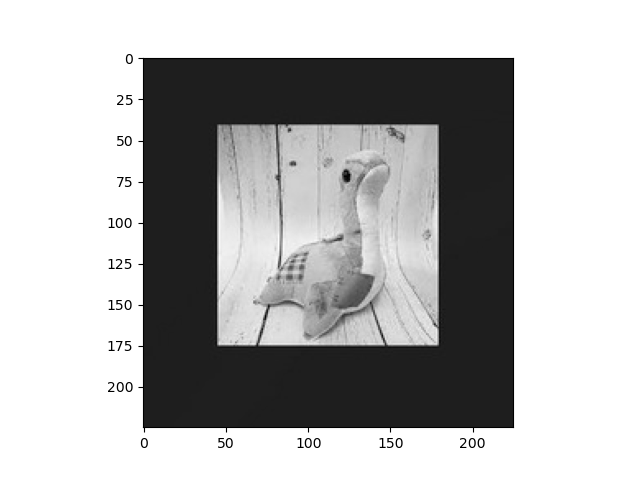

Polygon vertices:
[(48.03876287286931, 134.7272696309275), (61.43162001572645, 115.24675015040805), (101.00142521053164, 112.81168521534309), (111.35045118455761, 84.80843846209635), (147.87642521053164, 58.02272417638207), (159.44298365209008, 87.24350339716128), (172.22707456118098, 97.59252937118725), (138.74493170403815, 160.29545144910932), (62.649152483258916, 154.81655534521323)]


In [14]:
# images in the paper to ensure the correctness of the code
# source_img_path = "InputImgs\\1.png"
# target_img_path = "InputImgs\\2.png"

# my set of images
# The set of pictures I chose cannot clearly show the difference between importing gradient and mixing gradient, 
# so I used the set of pictures above to make sure my code is correct.
source_img_path = "InputImgs\\SrcImg.png"
target_img_path = "InputImgs\\DstImg.png"

source_img_grey = cv2.imread(source_img_path, cv2.IMREAD_GRAYSCALE)
target_img_grey = cv2.imread(target_img_path, cv2.IMREAD_GRAYSCALE)


def onselect(verts):
    global polygon
    polygon = [(y, x) for x, y in verts]
    print("Polygon vertices:")
    print(polygon)

# plot
fig, ax = plt.subplots()
ax.imshow(source_img_grey, cmap='gray')

# use PolygonSelector to select our polygon
polygon_selector = PolygonSelector(ax, onselect)
# plot image for polygon selection 
plt.show()

$$
\Delta f = 0 \text{ over } \Omega \text{ with } f|_{\partial \Omega} = f' |_{\partial \Omega}
$$


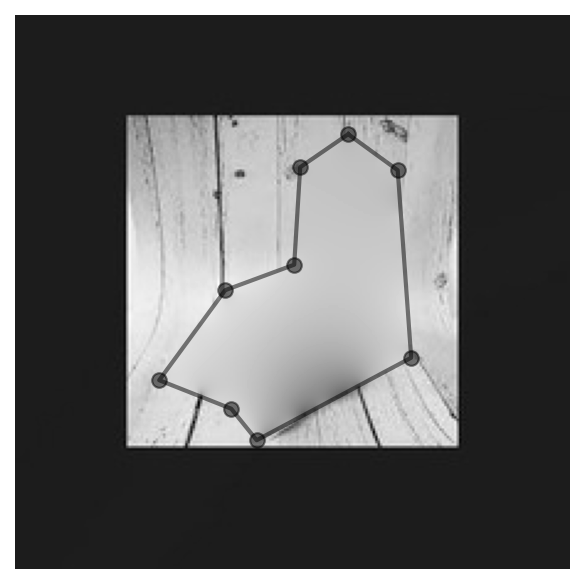

In [15]:
%matplotlib inline
from scipy.sparse.linalg import spsolve
from scipy.sparse import lil_matrix

try:
    _ = polygon
except NameError:
    polygon = [(49., 137.), (66., 160.6), (170., 141.), (169., 73.), (105., 63.)]
    print("Using the default polygon, you could also choose a specific polygen by running the cell above and click on the img showed")


gray_image = source_img_grey.copy()
image_height, image_width = gray_image.shape[:2]

# get the coordinates of the pixel in the mask
mask = polygon2mask((image_height, image_width), polygon)
interior_idx = np.argwhere(mask)

# initialize sparse matrix A and vector b
n_interior_pixels = len(interior_idx)
A = lil_matrix((n_interior_pixels, n_interior_pixels), dtype=float)
b = np.zeros(n_interior_pixels)

# consrtuct the equation
for i, (row, col) in enumerate(interior_idx):
    # main diagonal elements are all 4
    A[i, i] = 4
    # 4 - dir neighbours
    for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        neighbor = (row + drow, col + dcol)
        # neighbour in mask (indicates the current pixel is in destination domian)
        if mask[neighbor]:
            j = np.argwhere(np.all(interior_idx == neighbor, axis=1))[0, 0]
            A[i, j] = -1
        # neighbour not in mask (indicates the current pixel is in edge)
        # Dirichlet boundary condition
        else:
            b[i] += gray_image[neighbor]
            
# trans to CSR format to improve efficiency
# solve the equation
solution = spsolve(A.tocsr(), b)
# fill the solution into the corresponding area
for (solution_value, (row, col)) in zip(solution, interior_idx):
    gray_image[row, col] = solution_value

# plot
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

Q1: Test the method in smooth regions and also in regions with edges (high-frequency).    
A: The method works fine in smooth regions but in regions with edges (high-frequency), it loses a lot of texture details informations.  
  
Q2：Report the behavior as the size of the selected region increases.   
A: As the size of the selected region increases, it begins to lose more and more texture details informations.  

## Task2

In [16]:
# construct matrices array to get the first derivatives of imgs in 4 directions 
# for mixing gradients
# the add up result of this matrices array equals to laplacian kernel

kx_forward = np.array([
    [0, 0, 0],
    [0, -1, 1],
    [0, 0, 0]
])
ky_forward = np.array([
    [0, 0, 0],
    [0, -1, 0],
    [0, 1, 0]
])
kx_backward = np.array([
    [0, 0, 0],
    [1, -1, 0],
    [0, 0, 0]
])
ky_backward = np.array([
    [0, 1, 0],
    [0, -1, 0],
    [0, 0, 0]
])

derivative_matrices = np.array([kx_forward, ky_forward, kx_backward, ky_backward])

### importing grdients
$$
\Delta f = \Delta g \text{ over } \Omega, \text{ with } f|_{\partial \Omega} = f' |_{\partial \Omega}.
$$

### mixing grdients
$$
\text{for all } x \in \Omega, \quad v(x) = \begin{cases} 
\nabla f'(x), & \text{if } |\nabla f'(x)| > |\nabla g(x)|,\\
\nabla g(x), & \text{otherwise}.
\end{cases}
$$



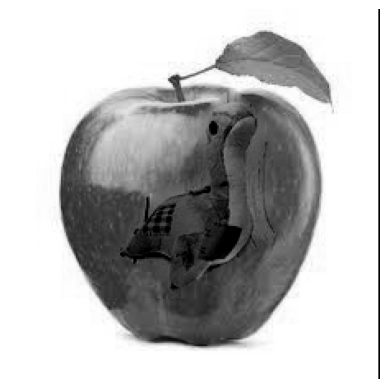

In [17]:
from scipy import signal


def seamless_cloning(source_img, target_img, mask, polygon, mode='importing'):
    # laplacian kernel
    laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    # compute images after laplacian filter
    grad_source = signal.convolve2d(source_img, laplacian, mode='same', boundary='fill', fillvalue=0)
    grad_target = signal.convolve2d(target_img, laplacian, mode='same', boundary='fill', fillvalue=0)

    # get the coordinates of the pixel in the mask
    idx = np.argwhere(mask)
    
    # initialize sparse matrix A and vector b
    n_pixels = len(idx)
    A = lil_matrix((n_pixels, n_pixels))
    b = np.zeros(n_pixels)

    # computer divergence in mixing gradient mode
    grads = []
    # in 4 directions
    for i in range(4):
        # compare the first derivative in the current direction and choose the larger one
        srcGrad = signal.convolve2d(source_img, derivative_matrices[i], mode='same', boundary='fill', fillvalue=0)
        dstGrad = signal.convolve2d(target_img, derivative_matrices[i], mode='same', boundary='fill', fillvalue=0)
        grads.append(np.where(np.abs(srcGrad) > np.abs(dstGrad), srcGrad, dstGrad))
    # sum the four gradients, which is sum the two divergences and we can get the final divergence
    divergence = np.sum(grads, axis=0)
    
    for i, (row, col) in enumerate(idx):
        A[i, i] = 4
        if mode == 'importing':
            b[i] -= grad_source[row, col]
        elif mode == 'mixing':
            b[i] -= divergence[row, col]

        # 4 - dir neighbours
        for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            neighbor = (row + drow, col + dcol)
            # neighbour in mask (indicates the current pixel is in destination domian)
            if mask[neighbor]:
                j = np.argwhere((idx == neighbor).all(axis=1))
                if j.size > 0:
                    A[i, j[0][0]] = -1
            # neighbour not in mask (indicates the current pixel is in edge)
            # Dirichlet boundary condition
            else:
                b[i] += target_img[neighbor]
    
    
    # trans to CSR format to improve efficiency
    # solve the equation
    solution = spsolve(A.tocsr(), b)

    # fill the solution into the corresponding area
    cloned_img = target_img.copy()
    for (row, col), value in zip(idx, solution):
        cloned_img[row, col] = np.clip(value, 0, 255)

    plt.imshow(cloned_img, cmap='gray')
    plt.axis('off')
    plt.show()
    return cloned_img

# importing gradient
seamless_cloning(source_img_grey, target_img_grey, mask, polygon, mode='importing');

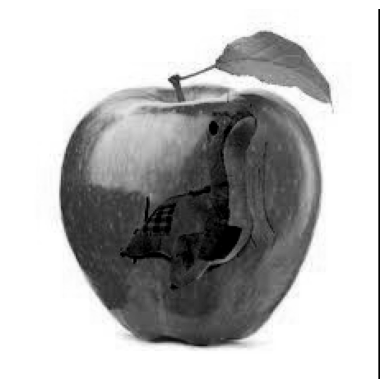

In [18]:
# mixing gradient
seamless_cloning(source_img_grey, target_img_grey, mask, polygon, mode='mixing');

## Task3

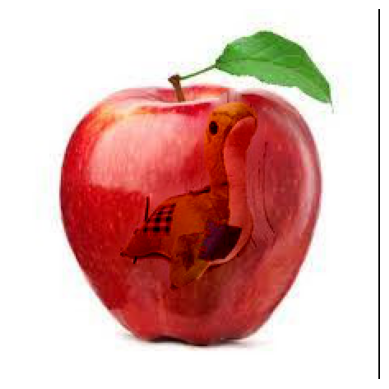

In [19]:
# gray to rgb
source_img = cv2.imread(source_img_path, cv2.IMREAD_COLOR)
target_img = cv2.imread(target_img_path, cv2.IMREAD_COLOR)

def seamless_cloning(source_img, target_img, mask, mode='importing'):
    cloned_img = np.empty_like(target_img)

    for channel in range(3):
        source_channel = source_img[:,:,channel]
        target_channel = target_img[:,:,channel]

        # compute Laplacian result
        laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
        grad_source = signal.convolve2d(source_channel, laplacian, mode='same', boundary='fill', fillvalue=0)
        grad_target = signal.convolve2d(target_channel, laplacian, mode='same', boundary='fill', fillvalue=0)

        # get the coordinates of the pixel in the mask
        idx = np.argwhere(mask)

        # initialize sparse matrix A and vector b
        n_pixels = len(idx)
        A = lil_matrix((n_pixels, n_pixels))
        b = np.zeros(n_pixels)

        # computer divergence in mixing gradient mode
        grads = []
        # in 4 directions
        for i in range(4):
            # compare the first derivative in the current direction and choose the larger one
            srcGrad = signal.convolve2d(source_channel, derivative_matrices[i], mode='same', boundary='fill', fillvalue=0)
            dstGrad = signal.convolve2d(target_channel, derivative_matrices[i], mode='same', boundary='fill', fillvalue=0)
            grads.append(np.where(np.abs(srcGrad) > np.abs(dstGrad), srcGrad, dstGrad)) # 哪个梯度大就取哪个

        # sum the four gradients, which is sum the two divergences and we can get the final divergence
        divergence = np.sum(grads, axis=0)
        
        for i, (row, col) in enumerate(idx):
            A[i, i] = 4
            if mode == 'importing':
                b[i] -= grad_source[row, col]
            elif mode == 'mixing':
                b[i] -= divergence[row, col]

            # 4 - dir neighbours
            for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                neighbor = (row + drow, col + dcol)
                # neighbour in mask (indicates the current pixel is in destination domian)
                if mask[neighbor]:
                        j = np.argwhere((idx == neighbor).all(axis=1))
                        A[i, j[0][0]] = -1
                # neighbour not in mask (indicates the current pixel is in edge)
                # Dirichlet boundary condition
                else:
                    b[i] += target_channel[neighbor]

        # trans to CSR format to improve efficiency
        # solve the equation
        solution = spsolve(A.tocsr(), b)

        # fill the solution into the corresponding area
        channel_cloned = target_channel.copy()
        for (row, col), value in zip(idx, solution):
            channel_cloned[row, col] = np.clip(value, 0, 255)
        cloned_img[:,:,channel] = channel_cloned

    plt.imshow(cv2.cvtColor(cloned_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    return cloned_img

# importing gradient
seamless_cloning(source_img, target_img, mask.astype(bool), mode='importing');


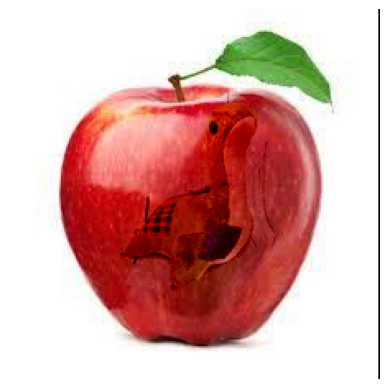

In [20]:
# mixing gradient
seamless_cloning(source_img, target_img, mask.astype(bool), mode='mixing');

## Task4 Texture Flattening

$$
\text{For all } x \in \Omega, \quad \mathbf{v}(x) = \mathbf{M}(x) \nabla f^*(x),       \\
\mathbf{M}(x) => Canny Edge Detection + EdgeMatrix \\
\text{In that Canny Result does not include direction information}
$$



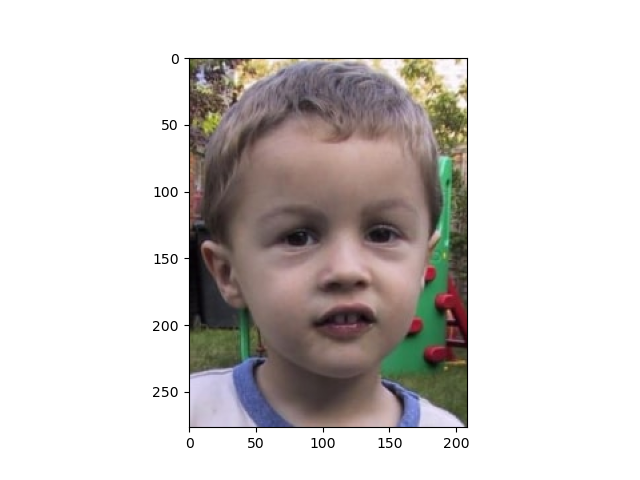

Polygon vertices:
[(101.22630726207387, 66.77687494888966), (97.47901288977948, 161.20869313070781), (122.21115574692234, 179.94516499217966), (212.89567955644617, 143.9711390181537), (215.89351505428164, 87.76172343373813), (135.7014154871821, 40.54581434282906)]


In [21]:
%matplotlib widget
img_path = "InputImgs//qwe.jpg"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

img_array = image.copy()

def onselect(verts):
    global polygon_flatten
    polygon_flatten = [(y, x) for x, y in verts]
    print("Polygon vertices:")
    print(polygon_flatten)

# plot
fig, ax = plt.subplots()
ax.imshow(img_array, cmap='gray')

# use PolygonSelector to select our polygon
polygon_selector = PolygonSelector(ax, onselect)

plt.show()

In [22]:
# construct matrices array to get the edges in 4 directions

kx_forward = np.array([
    [0, 0, 0],
    [0, 1, 1],
    [0, 0, 0]
])
ky_forward = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 1, 0]
])

kx_backward = np.array([
    [0, 0, 0],
    [1, 1, 0],
    [0, 0, 0]
])
ky_backward = np.array([
    [0, 1, 0],
    [0, 1, 0],
    [0, 0, 0]
])

edge_matrices = np.array([kx_forward, ky_forward, kx_backward, ky_backward])

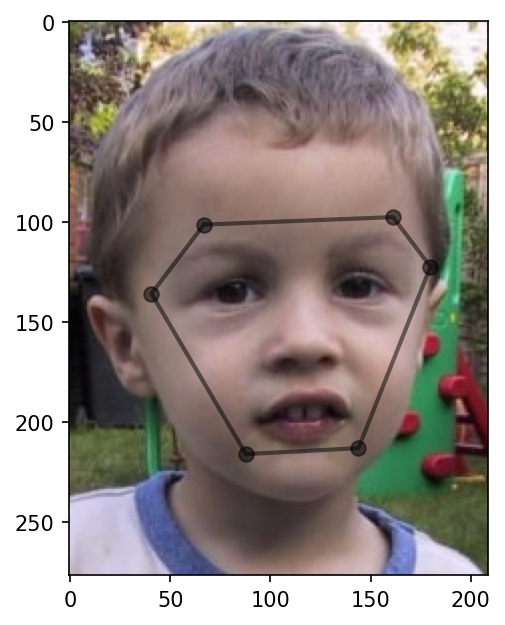

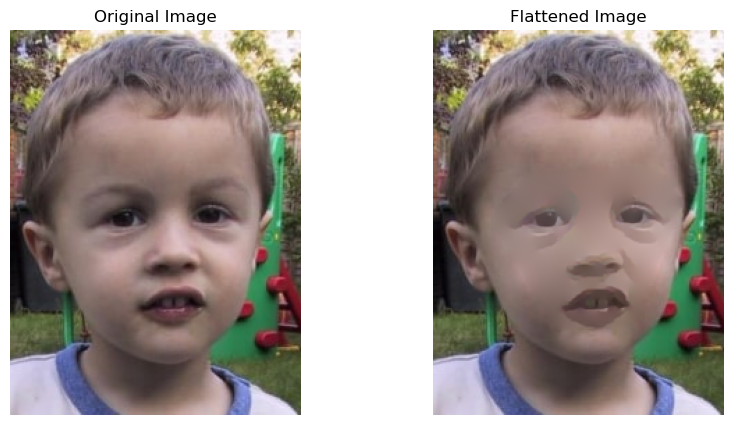

In [23]:
%matplotlib inline

try:
    _ = polygon_flatten
except NameError:
    polygon_flatten = [(101., 56.), (98., 161.), (134., 173.), (213., 138.), (218., 88.), (134., 46.)]
    print("Using the default polygon, you could also choose a specific polygen by running the cell above and click on the img showed")


def texture_flattening(source_img, mask):
    flattened_img = np.empty_like(source_img)

    for channel in range(3):
        source_channel = source_img[:, :, channel]

        # use cv2.canny to detect edges
        canny = cv2.Canny(source_channel, 80, 120)
        # we can`t use the result we get above directly because it is not directional
        # so we have to compute the edge points in all four directions by using the edge matrixe array we defined above
        edges = [signal.convolve2d(canny, edge_matrices[i], mode = 'same', boundary= 'fill', fillvalue=0) for i in range (4)]
        
        # compute the gradient in 4 directions
        grads = [signal.convolve2d(source_channel, derivative_matrices[i], mode = 'same', boundary= 'fill', fillvalue=0) for i in range (4)]

                
        # if the current pixel is not an edge point(even just in 1 dir), change the gradient to 0.
        for i in range(4):
            for j in range(edges[i].shape[0]):
                for k in range(edges[i].shape[1]):
                    # grads[i][j][k] *= edges[i][j][k] # （if edge = 1 / 0 instead of > 0 / 0）
                    if edges[i][j][k] == 0:
                        grads[i][j][k] = 0
        # sum the four gradients, which is sum the two divergences and we can get the final divergence
        div = np.sum(grads, axis=0)

        # get the coordinates of the pixel in the mask
        idx = np.argwhere(mask)

        # initialize sparse matrix A and vector b
        n_pixels = len(idx)
        A = lil_matrix((n_pixels, n_pixels))
        b = np.zeros(n_pixels) 

        for i, (row, col) in enumerate(idx):
            A[i, i] = 4
            b[i] -= div[row, col]
            for drow, dcol in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                neighbor = (row + drow, col + dcol)
                # neighbour in mask (indicates the current pixel is in destination domian)
                if mask[neighbor]:
                    j = np.argwhere((idx == neighbor).all(axis=1))
                    A[i, j[0][0]] = -1
                # neighbour not in mask (indicates the current pixel is in edge)
                # Dirichlet boundary condition
                else:
                    b[i] += source_channel[neighbor]

        # trans to CSR format to improve efficiency
        # solve the equation
        solution = spsolve(A.tocsr(), b)

        # fill the solution into the corresponding area
        channel_flattened = source_channel.copy()
        for (row, col), value in zip(idx, solution):
            channel_flattened[row, col] = np.clip(value, 0, 255)
        flattened_img[:, :, channel] = channel_flattened

    return flattened_img


image_height, image_width = image.shape[:2]
mask = polygon2mask((image_height, image_width), polygon_flatten);
flat_img = texture_flattening(image, mask);

# plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(flat_img)
axes[1].set_title('Flattened Image')
axes[1].axis('off')

plt.show()
